In [1]:
#A code to fit continuum, pseudo-continuum, and/or baselines to image cubes from the JWST nirspec ifu
#By Adam E. Rubinstein

# load important packages
from glob import glob
import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline
import os
import sys

from astropy import units as u
from astropy.io import fits
import pandas as pd
from spectral_cube import SpectralCube

Options forbaseline fitting

Asymmetric least squares smoother: from spectrapepper: https://github.com/spectrapepper/spectrapepper/blob/main/spectrapepper/functions.py

see function alsbaseline

last parameters that worked: smooth_list = [10000, 0.1, 0.1, 1, 10, 10, 0.1, 1], p_list = [0.05, 0.01, 0.05, 0.005, 0.0005, 0.01, 0.0001]


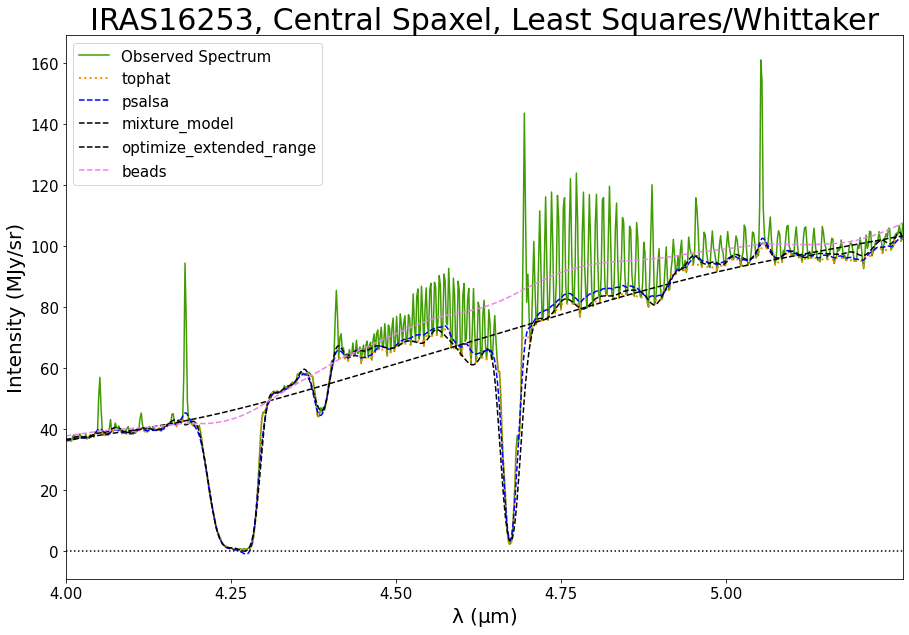

In [2]:
#testing templates and different interpolation schemes from pybaselines
from pybaselines import Baseline, utils

#make a figure to plot various locations on an image
fig, ax = plt.subplots(figsize=(15,10)) #setup fig, axes

#read in some data
cube_file_list = ['IRAS16253/jw01802-o015_t012_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'B335/jw01802-o003_t001_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'HOPS153/jw01802-o019_t015_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'HOPS370/jw01802-o007_t004_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'IRAS20126/jw01802-o011_t007_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits']
protostar_ind = 0 #CHANGE: to change protostars
hdul = fits.open(cube_file_list[protostar_ind])
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
cube = fits.getdata(cube_file_list[protostar_ind])

# define the wavelength grid (microns) from the header
wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1]

# extracting spectra
central_sources = [(48,46), (44,43), (46, 48), (41, 45), (38, 42)] #centered on a location with more lines, better with knots...
flux_1pix = cube[:, central_sources[protostar_ind][0], central_sources[protostar_ind][1]][1:-1] #for an example of a single pixel, but cut off the ends of the spectrum for better fitting results
ax.plot(wave, flux_1pix, color='xkcd:grassy green', label='Observed Spectrum') #plot observation here!

#compute baseline with pybaselines
'''NOTES
Seems like the best ones per category are 
(whittaker) arpls with diff_order=3 or maybe psalsa (but tougher to tune), 
(morphological) jbcd or mwmv or tophat or ...imor with half_window=1 (too many parameters), 
(spline) maybe mixture_model or pspline_psalsa 
(smoothing), ria or ipsa
(classification), ???
(optimizer and misc) potential for solving for an actual baseline...
'''
baseline_fitter = Baseline(wave, check_finite=False)

#summary of best...
# # bkg_3 = baseline_fitter.arpls(flux_1pix, lam=0.05, diff_order=3)[0]
# # ax.plot(wave, bkg_3, label='arpls', linestyle='-') #baseline
# bkg_1 = baseline_fitter.jbcd(flux_1pix, half_window=3,alpha=100, diff_order=2)[0]
# bkg_5 = baseline_fitter.mwmv(flux_1pix, half_window=2, smooth_half_window=2)[0]
# ax.plot(wave, bkg_5, label='Moving Window at Min Val', linestyle='-', color='red') #baseline
# ax.plot(wave, bkg_1, label='Correcting and Denoising Least Squares', linestyle='-.', color='blue') #baseline
# # bkg_1 = baseline_fitter.ria(flux_1pix, sigma_scale=0.004, half_window=1)[0]
# bkg_4 = baseline_fitter.ipsa(flux_1pix, half_window=4)[0]
# # ax.plot(wave, bkg_1, label='ria', linestyle='--', color='black') #baseline
# ax.plot(wave, bkg_4, label='Iterative Polynomial Smoothing', linestyle='--', color='black') #baseline

#morphological
bkg_top = baseline_fitter.tophat(flux_1pix, half_window=3)[0]
# bkg_1 = baseline_fitter.jbcd(bkg_top, half_window=10,alpha=1)[0]
# bkg_3 = baseline_fitter.imor(bkg_top, half_window=1)[0]
# bkg_4 = baseline_fitter.rolling_ball(bkg_top, half_window=10)[0]
# bkg_5 = baseline_fitter.mwmv(bkg_top, half_window=4)[0]
ax.plot(wave, bkg_top, color='darkorange', label='tophat', linestyle=':',lw=2) #baseline
# ax.plot(wave, bkg_3, color='cyan', label='Improved Morphological', linestyle='-.') #baseline
# ax.plot(wave, bkg_4, color='violet', label='rolling_ball', linestyle='--') #baseline
# ax.plot(wave, bkg_5, color='gray', label='Moving Window at Min Val', linestyle='-') #baseline
# ax.plot(wave, bkg_1, 'black', label='Correcting and Denoising Least Squares', linestyle='--') #baseline
# ax.set_title(cube_file_list[protostar_ind].split('/')[0] + ', Central Spaxel, Morphological', fontsize=30)

#whittaker
# bkg_1 = baseline_fitter.drpls(flux_1pix, lam=1000, eta=0.99)[0]
bkg_2 = baseline_fitter.aspls(flux_1pix, lam=1e4)[0]
# bkg_3 = baseline_fitter.arpls(flux_1pix, lam=1000, diff_order=3)[0]
bkg_4 = baseline_fitter.psalsa(flux_1pix, lam=10, p=0.1, k=50)[0]
# ax.plot(wave, bkg_1, 'black', label='drpls', linestyle='--') #baseline
# ax.plot(wave, bkg_2, 'purple', label='aspls', linestyle=':') #baseline
# ax.plot(wave, bkg_3, 'red', label='arpls', linestyle='-.') #baseline
ax.plot(wave, bkg_4, color='blue', label='psalsa', linestyle='--') #baseline
ax.set_title(cube_file_list[protostar_ind].split('/')[0] + ', Central Spaxel, Least Squares/Whittaker', fontsize=30)

#spline
bkg_1 = baseline_fitter.mixture_model(flux_1pix, lam=0.001, num_knots=160)[0]
# bkg_3 = baseline_fitter.pspline_arpls(flux_1pix, lam=0.0001, diff_order=3, num_knots=160)[0]
# bkg_4 = baseline_fitter.pspline_psalsa(flux_1pix, lam=0.01, k=10, num_knots=300)[0]
ax.plot(wave, bkg_1, 'black', label='mixture_model', linestyle='--') #baseline
# ax.plot(wave, bkg_3, 'red', label='pspline_arpls', linestyle='-.') #baseline
# ax.plot(wave, bkg_4, color='cyan', label='pspline_psalsa', linestyle='--') #baseline
# ax.set_title(cube_file_list[protostar_ind].split('/')[0] + ', Central Spaxel, Splining', fontsize=30)

#smoothing
# bkg_1 = baseline_fitter.ria(bkg_top, sigma_scale=0.01, half_window=10)[0]
# bkg_2 = baseline_fitter.snip(bkg_top, max_half_window=4)[0]
# bkg_4 = baseline_fitter.ipsa(bkg_top, half_window=10)[0]
# ax.plot(wave, bkg_1, 'black', label='ria', linestyle='--') #baseline
# ax.plot(wave, bkg_2, 'red', label='snip', linestyle=':') #baseline
# ax.plot(wave, bkg_4, color='blue', label='ipsa', linestyle='-.') #baseline
# ax.set_title(cube_file_list[protostar_ind].split('/')[0] + ', Central Spaxel, Smoothing', fontsize=30)

#classification
# bkg_1 = baseline_fitter.cwt_br(bkg_top, poly_order=8, num_std=10, min_length=1, scales=10)[0]
# bkg_2 = baseline_fitter.fabc(bkg_top, lam=0.1, scale=5, num_std=4, diff_order=1)[0]
# ax.plot(wave, bkg_1, 'black', label='cwt_br', linestyle='--') #baseline
# ax.plot(wave, bkg_2, '^', label='fabc', linestyle=':') #baseline
# ax.set_title(cube_file_list[protostar_ind].split('/')[0] + ', Central Spaxel, Classifiers', fontsize=30)

#optimizer
bkg_1 = baseline_fitter.optimize_extended_range(bkg_top, sigma_scale=1, min_value=7, max_value=9, method='aspls')[0]
# print(baseline_fitter.optimize_extended_range(bkg_top, sigma_scale=0.1, min_value=3, max_value=10, method='aspls')[1])
bkg_4 = baseline_fitter.beads(flux_1pix, smooth_half_window=2,  asymmetry=0.25, lam_0=10)[0]
ax.plot(wave, bkg_1, 'black', label='optimize_extended_range', linestyle='--') #baseline
ax.plot(wave, bkg_4, color='violet', label='beads', linestyle='--') #baseline
# ax.set_title(cube_file_list[protostar_ind].split('/')[0] + ', Central Spaxel, Optimizers and Misc', fontsize=30)

#formatting plot
# ax.plot(wave, baseline_list, color='xkcd:twilight blue', label='Line Emission') #data
# ax.set_yscale('log') #if you would like to set a log scale
ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
ax.legend(loc='best', fontsize=15)
ax.set_xticks(np.arange(3, 5.25, 0.25))
ax.set_xlim(4, np.max(wave))
# ax.set_ylim(np.min(np.nan_to_num(flux_1pix))*30,np.max(np.nan_to_num(flux_1pix))*0.8)
# ax.set_ylim(0,1000)
ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=20)
ax.set_ylabel('Intensity (MJy/sr)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
# fig.savefig('CentralSource_CO/' + cube_file_list[protostar_ind].split('/')[0]+'_FindBaseline.pdf')

# Applying Baseline Techniques

In [4]:
#setting up some initial lists

from pybaselines import Baseline, misc #, utils
from scipy.signal import medfilt, savgol_filter

#used for plotting
protostar_names = ['IRAS 16253-2429', 'B335', 'HOPS 153', 'HOPS 370', 'IRAS 20126+4104'] 

#the original data
cube_file_list = ['IRAS16253/jw01802-o015_t012_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'B335/jw01802-o003_t001_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'HOPS153/jw01802-o019_t015_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'HOPS370/jw01802-o007_t004_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    '12_22_23_20126_update/jw01802-o011_t007_nirspec_g395m-f290lp_wcs1_s3d.fits'
                    # 'IRAS20126/jw01802-o011_t007_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits'
                    ]

#derived data or cubes
protostar_substr = ['IRAS16253', 'B335', 'HOPS153', 'HOPS370', 'IRAS20126']
absorb_emiss_path = 'Extended_CO_CO2/CO_Absorption_Emission_Maps/'
absorb_emiss_cube_list = [glob(absorb_emiss_path + i + '*cube*.fits')[0].replace('\\', '/') for i in protostar_substr]
absorb_emiss_txt_list = [glob(absorb_emiss_path + i + '*txt')[0].replace('\\', '/') for i in protostar_substr]

# central_sources = [(46.57459417809592, 45.12978229),  (46.73250708463416, 43.13112798), \
                #    (46.47088442936513, 46.6279981), (41.71119797770727, 43.61467905), \
                    # (43.38667807448542, 43.15705917)]

In [263]:
# an alternative approach partially by you.com chatbot AI - would need editing to functionalize, but would be very convenient
# wave_cutoff_inds = np.array([np.abs(wave - i).argmin() for i in wave_cutoff_list])
# wave_sectioned = np.split(wave, wave_cutoff_inds)
# flux_sectioned =  np.split(flux_1pix, wave_cutoff_inds)
# baseline_list = np.array([baseline_fitter.jbcd(np.split(bkg_top, wave_cutoff_inds)[i], half_window=smooth_list[i],alpha=alpha_list[i])[0] for i in range(len(wave_cutoff_inds))]).flatten()

# baseline_list = np.zeros_like(wave)
# for i in range(len(wave_cutoff_list) - 1):
#     idx = (wave >= wave_cutoff_list[i]) & (wave < wave_cutoff_list[i+1])
#     mask = np.where(idx)[0]
#     baseline_fitter = Baseline(wave[mask], check_finite=False)
#     baseline = baseline_fitter.jbcd(bkg_top[mask], half_window=smooth_list[i], alpha=alpha_list[i])[0]
#     baseline_list[mask] = baseline

#yet another alternative where we're trying to fit each line individually for absorption or emission..
#     #absorption, colored as blue
    #     if line_absorb_emiss_match == -1: 
    #         baseline = baseline_fitter.pspline_asls(line_flux_match, p=0.99999, lam=1e6)[0]
    #     #emission, colored as yellow
    #     elif line_absorb_emiss_match == +1: 
    #         baseline = baseline_fitter.pspline_asls(line_flux_match, p=0.00001, lam=1e6)[0]
    #     #neither, but the neighbors match so we know it's probably the same as the others
    #     elif line_absorb_emiss_match == 0 and cube_absorb_emiss[line-1, int(source_coords[i][0]), int(source_coords[i][1])] \
    #                                                 == cube_absorb_emiss[line+1, int(source_coords[i][0]), int(source_coords[i][1])]: 
    #         if cube_absorb_emiss[line-1, int(source_coords[i][0]), int(source_coords[i][1])] == -1:
    #             baseline = baseline_fitter.pspline_asls(line_flux_match, p=0.99999, lam=1e6)[0]
    #         elif cube_absorb_emiss[line-1, int(source_coords[i][0]), int(source_coords[i][1])] == +1:
    #             baseline = baseline_fitter.pspline_asls(line_flux_match, p=0.00001, lam=1e6)[0]
    #     #neither, but we can't come up with a good basis to guess off of, maybe do it in the middle?
    #     else: 
    #         #could do tophat, pspline, asls, whatever gets a smooth curve or through the middle of the noise
    #         baseline = baseline_fitter.pspline_asls(line_flux_match, p=0.01, lam=1e6)[0] # [np.nan]*len(line_flux_match) # baseline_fitter.tophat(line_flux_match, half_window=3)[0]
        
    #     #then store in a list
    #     co_baseline_list = np.concatenate((co_baseline_list, baseline))
    #     co_wave_list = np.concatenate((co_wave_list, wave[line_wave_idx-2 : line_wave_idx+2])) #finding associated wavelengths for interpolation later

    #now we need to reprocess and smooth this baseline list
    #first attempt an interpolation to get back to the original grid we had
    # f_interp = interp1d(co_wave_list, co_baseline_list, assume_sorted = False)
    # co_wave_interp = wave[(wave > co_refs_txt[0][1]) * (wave < co_refs_txt[-2][1])]

    # baseline_interpolated = f_interp(co_wave_interp) #from scipy

    # #not smoothed enough, so then we refit the new baseline (generally getting the correct envelope or initial guess)
    # baseline_fitter = Baseline(co_wave_interp, check_finite=False)
    # baseline_smoothed = baseline_fitter.jbcd(baseline_interpolated, half_window=4, alpha=100)[0]



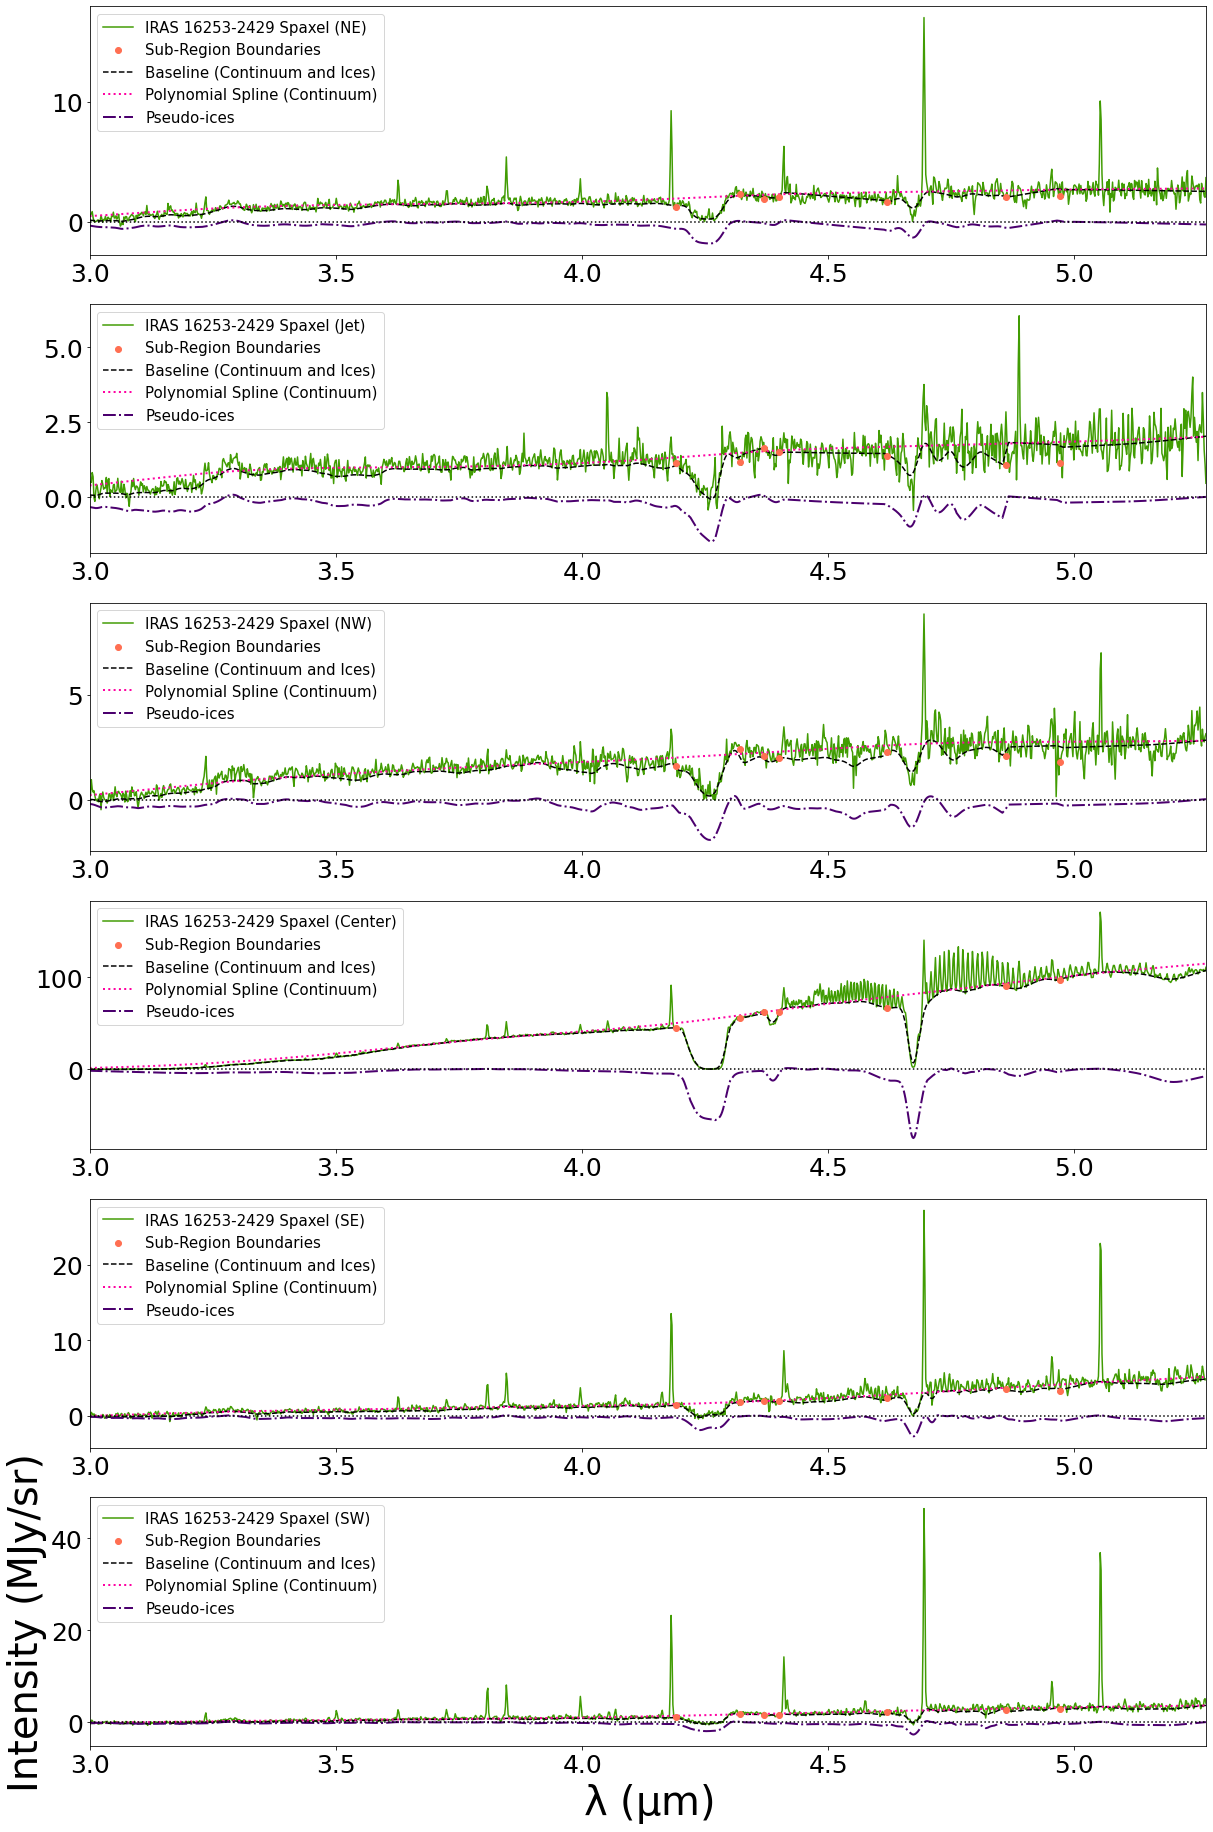

In [264]:
#testing an initial filter + interpolation for baselines

#read in some data
protostar_ind = 0 #CHANGE: to change protostars
hdul = fits.open(cube_file_list[protostar_ind])
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
cube = fits.getdata(cube_file_list[protostar_ind])
err_cube = hdul['ERR'].data

# define the wavelength grid (microns) from the header, always the same
wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1]

#now that we have chosen a protostar...
#create list of coordinates and wavelength regimes to loop over; also labels for the different locations
source_coords = [(64, 30),  (70, 37), (74, 52), (48, 47), (33, 49), (37, 64)] #note these coordinates can be flipped relative to the image reader
source_labels = ['NE', 'Jet', 'NW', 'Center', 'SE', 'SW']
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.86, 4.971])
smooth_list = [1, 1, 10, 1, 5, 3, 5, 2] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 1, 100, 5, 7] #regularization parameter (relative levels of noise and signal)
# param_secondtolast = [2, 7]

#then set up a figure to loop over
fig, ax_list = plt.subplots(figsize=(20,32), nrows=6) #setup fig, axes #make a figure to plot various locations on an image

#and loop over the axes and coordinates for a given object
for i in range(len(ax_list)):
    ax = ax_list[i]

    # extracting spectra
    # cont_sources = [(48,46), (32,30), (46, 47), (62, 67), (48, 46)] #centered on a location with fewer lines, better for smoothing directly
    # flux_1pix = cube[:, cont_sources[protostar_ind][0], cont_sources[protostar_ind][1]] 
    # source_coords = [(48,46), (44,44), (44, 41), (41, 45), (38, 42)] #centered on a location with more lines, better with knots...also for fewer artifacts
    flux_1pix = cube[:, int(source_coords[i][0]), int(source_coords[i][1]) ][1:-1] #for an example of a single pixel, but cut off the ends of the spectrum for better fitting results
    err_1pix = err_cube[:, int(source_coords[i][0]), int(source_coords[i][1]) ][1:-1] #used later when trying to check if spectrum has high S/N
    # flux_1pix = flux_1pix[wave_mask]
    ax.plot(wave, flux_1pix, color='xkcd:grassy green', label=protostar_names[protostar_ind] + ' Spaxel ' + '(' + source_labels[i] + ')') #plot observation here!

    #preset the top hat filter version
    baseline_fitter = Baseline(wave, check_finite=False)
    bkg_top = baseline_fitter.tophat(flux_1pix, half_window=3)[0]

    #formulating regimes to cutoff the spectrum and apply different smoothing factors
    cutoffs_flux_matched = bkg_top[[np.abs(wave - j).argmin() for j in wave_cutoff_list]]
    ax.scatter(wave_cutoff_list, cutoffs_flux_matched, color='xkcd:orange pink', zorder=100, label='Sub-Region Boundaries') #or can use oranges 

    #begin to loop through different parameters, defining a new baseline for a given section of the spectrum
    baseline_list = []

    #if edge case at start, do it by hand to omit conditionals
    # print('start', wave_cutoff_list[0])
    cutoff_mask = wave < wave_cutoff_list[0] #define mask up to first marker
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #if between two values and not at the edge cases, we loop..
    cutoff_ind = 1 #to count loops
    while cutoff_ind <= len(wave_cutoff_list)-1:
        idx = (wave >= wave_cutoff_list[cutoff_ind-1]) & (wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with *
        cutoff_mask = np.where(idx)[0] #determine mask between two values
        # print('middle checks: ', cutoff_ind, wave_cutoff_list[cutoff_ind], len(flux_1pix[cutoff_mask]))

        #compute baseline
        baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)

        #check if relatively high S/N or not...if so, can do way following approx bottoms, else take median
        if np.mean(flux_1pix[cutoff_mask] / err_1pix[cutoff_mask]) < 8 and cutoff_ind != 1 and cutoff_ind != len(wave_cutoff_list)-2:
            baseline = baseline_fitter.pspline_asls(flux_1pix[cutoff_mask], lam=5e6, p=0.45, spline_degree=3)[0] 
            # baseline = baseline_fitter.tophat(baseline, half_window=6)[0] 
        elif np.mean(flux_1pix[cutoff_mask] / err_1pix[cutoff_mask]) < 8:
            baseline = baseline_fitter.noise_median(bkg_top[cutoff_mask], half_window=6)[0] 
            baseline = baseline_fitter.pspline_asls(baseline, lam=5e1, p=0.5, spline_degree=2)[0] 
            # baseline = baseline_fitter.jbcd(baseline, half_window=2,alpha=5)[0]
        else: #default to original if we can't figure anything else out...
            baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
            # baseline = baseline_fitter.pspline_asls(flux_1pix[cutoff_mask], lam=1e4, p=0.3, spline_degree=3)[0]
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #update counter for loop, do after everything else
        cutoff_ind += 1

    #if edge case at end, do it by hand
    # print('end', wave_cutoff_list[-1]) #print to confirm cutoff at end
    cutoff_mask = wave > wave_cutoff_list[-1] #define mask past last marker
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    if np.mean(flux_1pix[cutoff_mask] / err_1pix[cutoff_mask]) < 8:
        baseline = baseline_fitter.pspline_asls(flux_1pix[cutoff_mask], lam=5e5, p=0.4, spline_degree=2)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
    else:
        baseline = baseline_fitter.pspline_asls(flux_1pix[cutoff_mask], lam=1e3, p=0.1, spline_degree=3)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
        # baseline = baseline_fitter.jbcd(flux_1pix[cutoff_mask], half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #now trying to filter around our control or anchor points
    N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
    for cutoff_ind in range(len(wave_cutoff_list)):
        idx = ( wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
        idx_mask = np.where(idx)[0] #making mask
        baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=7) #in region around mask, apply filters

    #plotting 
    ax.plot(wave, baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
    # ax.plot(wave, flux_1pix-baseline_list, color='xkcd:twilight blue', label='Line Emission') #data

    #formulating a pseudo-continuum based on the baseline to determine ices and a transmission curve
    baseline_fitter = Baseline(wave, check_finite=False)
    ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e3, p=0.99, spline_degree=3)[0]
    ax.plot(wave, ice_list, linewidth=2, color='xkcd:shocking pink', linestyle=':', label='Polynomial Spline (Continuum)') # or can use xkcd:carnation pink
    ax.plot(wave, baseline_list - ice_list, linewidth=2, color='xkcd:royal purple', linestyle='-.', label='Pseudo-ices')

    #formatting plot
    ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
    # ax.set_xticks(np.arange(3, 5.25, 0.25))
    ax.set_xlim(3, np.max(wave))
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.legend(loc='best', fontsize=15)
    if i == len(ax_list) - 1:
        ax.set_ylabel('Intensity (MJy/sr)', fontsize=40)
        ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
    # fig.savefig('CentralSource_CO/' + cube_file_list[protostar_ind].split('/')[0]+'_FindBaseline.pdf')

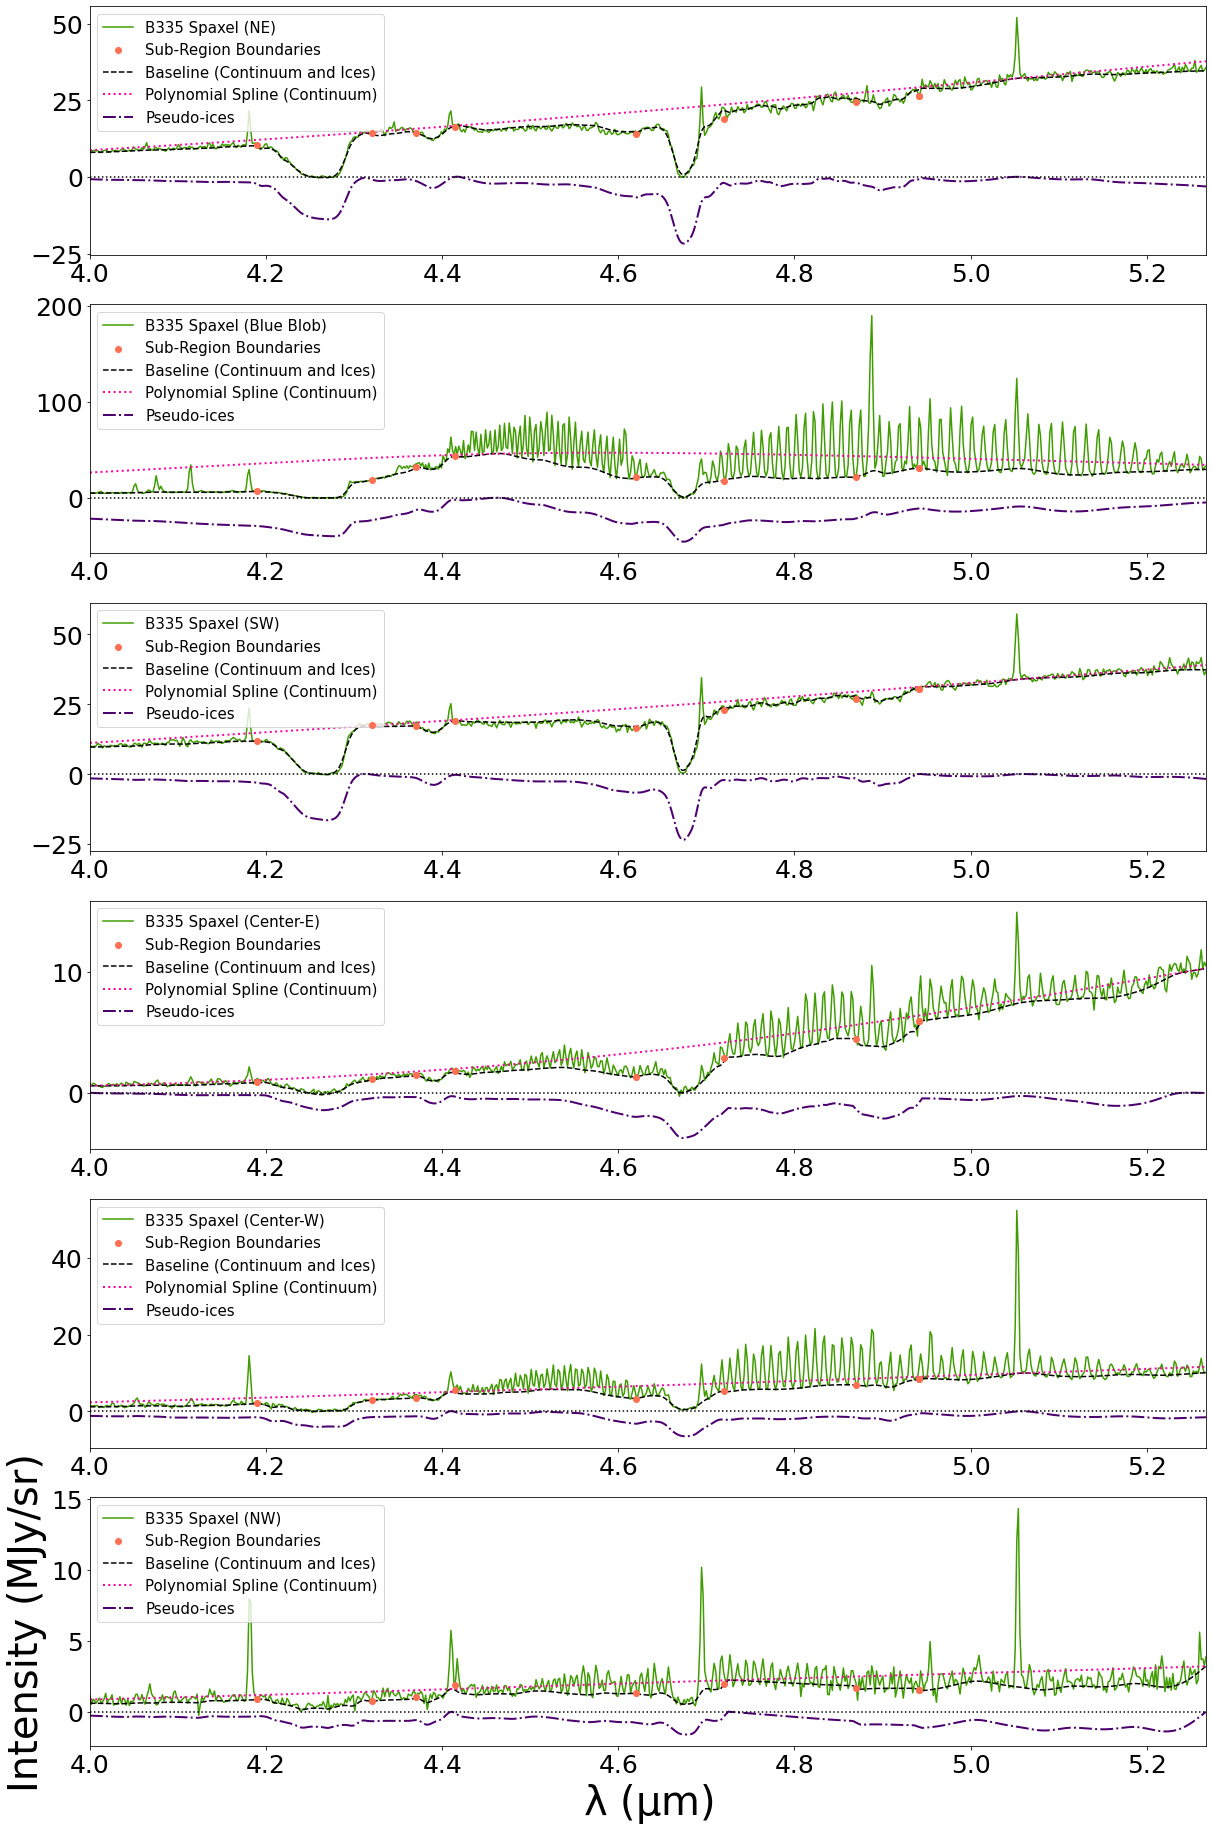

In [265]:
#testing an initial filter + interpolation for baselines

#read in some data
protostar_ind = 1 #CHANGE: to change protostars
hdul = fits.open(cube_file_list[protostar_ind])
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
cube = fits.getdata(cube_file_list[protostar_ind])
cube_err = hdul['ERR'].data #the corresponding noise plane...may be useful test if the absorption/emission check fails

# define the wavelength grid (microns) from the header, always the same
wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1]

#read in a cube that shows if each co line is in emission or absorption
cube_absorb_emiss = fits.getdata(absorb_emiss_cube_list[protostar_ind])
co_refs_txt = np.genfromtxt(absorb_emiss_txt_list[protostar_ind], delimiter=',', skip_header=1) # text file used to match indices to a given CO line

#now that we have chosen a protostar...
#create list of coordinates and wavelength regimes to loop over; also labels for the different locations
source_coords = [(55, 22),  (45, 28), (36, 20), (46, 45), (42, 54), (52, 72)]
source_labels = ['NE', 'Blue Blob', 'SW', 'Center-E', 'Center-W', 'NW']
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.415, 4.62, 4.72, 4.87, 4.941])
smooth_list = [1, 1, 10, 1, 5, 3, 7, 2, 10] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 100, 7, 0.1] #regularization parameter (relative levels of noise and signal)
# param_secondtolast = [2, 7]

#then set up a figure to loop over
fig, ax_list = plt.subplots(figsize=(20,32), nrows=6) #setup fig, axes #make a figure to plot various locations on an image

#and loop over the axes and coordinates for a given object
for i in range(len(ax_list)):
    ax = ax_list[i]

    # extracting spectra
    flux_1pix = cube[:, int(source_coords[i][0]), int(source_coords[i][1]) ][1:-1] #for an example of a single pixel, but cut off the ends of the spectrum for better fitting results
    err_1pix = cube_err[:, int(source_coords[i][0]), int(source_coords[i][1]) ][1:-1]
    ax.plot(wave, flux_1pix, color='xkcd:grassy green', label=protostar_names[protostar_ind] + ' Spaxel ' + '(' + source_labels[i] + ')') #plot observation here!
    # ax.plot(wave, err_1pix, color='xkcd:twilight blue', label=protostar_names[protostar_ind] + ' Noise ' + '(' + source_labels[i] + ')') #plot observation here!

    #preset the top hat filter version
    baseline_fitter = Baseline(wave, check_finite=False)
    bkg_top = baseline_fitter.tophat(flux_1pix, half_window=3)[0]

    #begin to loop through different parameters, defining a new baseline for a given section of the spectrum
    baseline_list = []
    wave_cutoff_mod_list = [] #updated version of the above list...

    #if edge case at start, do it by hand to omit conditionals
    cutoff_mask = wave < wave_cutoff_list[0] #define mask up to first marker
    wave_cutoff_mod_list.append(wave_cutoff_list[0]) #just so we're consistent with the start and ending points
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list


    #if between two values and not at the edge cases, we loop..
    cutoff_ind = 1 #to count loops
    while cutoff_ind <= len(wave_cutoff_list)-1:
        #take region of spectrum
        idx = (wave >= wave_cutoff_list[cutoff_ind-1]) & (wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with * or & from PRIOR breakpoint
        cutoff_mask = np.where(idx)[0] #determine mask between two values
        baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)

        #loop through many CO spectral lines to determine each individual baseline 
        if wave_cutoff_list[cutoff_ind] < 4.45: # len(co_line_wave_mask) == 0: #first check if we have to either by # of CO lines or wavelength itself
            wave_cutoff_mod_list.append(wave_cutoff_list[cutoff_ind])
            baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
        else:
            #search for CO lines in the wavelength region we are concerned with
            #first, mask the text file array of lines using the initial cutoff point GUESSES, which we'll use to update the points
            # co_line_boundary_mask = np.where((co_refs_txt[:, 1] >= wave_cutoff_list[cutoff_ind] - 0.1) \
            #                              & (co_refs_txt[:, 1] <= wave_cutoff_list[cutoff_ind] + 0.1))[0]

            #first we find corresponding matched lines by wavelength from our co_txt and the set's mode in cube_absorp_emiss
            # line_absorb_emiss_boundaries = cube_absorb_emiss[co_line_boundary_mask, int(source_coords[i][0]), int(source_coords[i][1])]
            
            # before computing the mode, we want to actually modify our breakpoints...
            '''
            now move the break point to a spot between -1 to +1 or +1 to -1 (signifying the absorption to emission switchover)
            ...maybe see if that spot is guaranteed by having +/- 10 array elements on either side having a constant sign?
            THIS spot gets plotted on the spectrum, then we can continue...
            ''' 
            # cutoff_index = point where we have the most +1 or -1 on either side...but what if all -1 or all +1?
            # np.diff(np.sign(line_absorb_emiss_boundaries))
            # wave_cutoff_mod = wave_cutoff_list[cutoff_ind] +/- 0.1 '???'
            wave_cutoff_mod_list.append(wave_cutoff_list[cutoff_ind])

            #given newly updated cutoffs, we compute the mode of the region to see if mostly absorption or emission
            co_line_wave_mask = np.where((co_refs_txt[:, 1] >= wave_cutoff_mod_list[cutoff_ind-1]) \
                                & (co_refs_txt[:, 1] <= wave_cutoff_mod_list[cutoff_ind]))[0]
            line_absorb_emiss_match = cube_absorb_emiss[co_line_wave_mask, int(source_coords[i][0]), int(source_coords[i][1])]
            vals, counts = np.unique(line_absorb_emiss_match, return_counts=True) #find number of unique elements of -1, 1, or 0 to determine bool
            absorb_emiss_mode = vals[np.argmax(counts)] #count bools to determine mode

            #now using the mode to pick and compute the correct baseline
            if absorb_emiss_mode == 1 and (cutoff_ind == len(wave_cutoff_list)-1 or cutoff_ind == len(wave_cutoff_list)-2) \
                                                                and np.mean(flux_1pix[cutoff_mask] / err_1pix[cutoff_mask]) < 8: #emission, do old way
                # baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
                baseline = baseline_fitter.pspline_asls(flux_1pix[cutoff_mask], lam=1e5, p=0.15, spline_degree=3)[0]
                # baseline = baseline_fitter.noise_median(baseline, half_window=2)[0] 
            elif absorb_emiss_mode == 1:
                baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
            elif absorb_emiss_mode == -1: #absorption, change slightly
                baseline = baseline_fitter.pspline_asls(flux_1pix[cutoff_mask], p=0.9, lam=5e1)[0]
                # baseline = baseline_fitter.noise_median(flux_1pix[cutoff_mask], half_window=2)[0] 
            elif np.mean(flux_1pix[cutoff_mask] / bkg_top[cutoff_mask]) > 1.1: #next, have to check the averaged signal to noise...compare to tophat and see if > 10% of it
                    baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
            else: #default to original if we can't figure anything else out...
                # baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
                baseline = baseline_fitter.noise_median(flux_1pix[cutoff_mask], half_window=2)[0] 
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #update counter for loop, do after everything else
        cutoff_ind += 1

    #if edge case at end, do it by hand
    cutoff_mask = wave > wave_cutoff_list[-1] #define mask past last marker
    wave_cutoff_mod_list.append(wave_cutoff_list[-1]) #for consistency
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    #given newly updated cutoffs, we compute the mode of the region to see if mostly absorption or emission
    co_line_wave_mask = np.where((co_refs_txt[:, 1] >=  wave_cutoff_mod_list[cutoff_ind]))[0]
    line_absorb_emiss_match = cube_absorb_emiss[co_line_wave_mask, int(source_coords[i][0]), int(source_coords[i][1])]
    vals, counts = np.unique(line_absorb_emiss_match, return_counts=True) #find number of unique elements of -1, 1, or 0 to determine bool
    absorb_emiss_mode = vals[np.argmax(counts)] #count bools to determine mode
    #now can fit the last portion for real!
    if absorb_emiss_mode == 1 and np.mean(flux_1pix[cutoff_mask] / err_1pix[cutoff_mask]) < 8: #emission, do old way
        baseline = baseline_fitter.pspline_asls(flux_1pix[cutoff_mask], lam=1e4, p=0.1, spline_degree=3)[0]        
    # elif absorb_emiss_mode == 1:
    #     baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
    # elif absorb_emiss_mode == -1: 
    #     baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=1e2, p=0.999, spline_degree=2)[0]
    else:
        # baseline = baseline_fitter.noise_median(flux_1pix[cutoff_mask], half_window=20)[0] 
        baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=2e2, p=0.8, spline_degree=3)[0]
        # baseline = baseline_fitter.pspline_asls(flux_1pix[cutoff_mask], lam=2e5, p=0.5, spline_degree=3)[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list


    # if np.mean(flux_1pix[cutoff_mask] / err_1pix[cutoff_mask]) < 8:
    #     baseline = baseline_fitter.pspline_asls(flux_1pix[cutoff_mask], lam=5e5, p=0.4, spline_degree=2)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
    # else:
    #     baseline = baseline_fitter.pspline_asls(flux_1pix[cutoff_mask], lam=1e3, p=0.1, spline_degree=3)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
    #     # baseline = baseline_fitter.jbcd(flux_1pix[cutoff_mask], half_window=smooth_list[-1],alpha=alpha_list[-1])[0]




    #now that we're done with the bulk of fitting...
    #formulating regimes to cutoff the spectrum and apply different smoothing factors
    cutoffs_flux_matched = bkg_top[[np.abs(wave - j).argmin() for j in wave_cutoff_mod_list]]
    # ax.scatter(wave_cutoff_list, [0]*len(wave_cutoff_list), color='xkcd:red', zorder=100, label='Original Sub-Region Boundaries') #or can use oranges 
    ax.scatter(wave_cutoff_mod_list, cutoffs_flux_matched, color='xkcd:orange pink', zorder=100, label='Sub-Region Boundaries') #or can use oranges 


    # now trying to filter around our control or anchor points
    N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
    for cutoff_ind in range(len(wave_cutoff_list)-1):
        idx = ( wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
        idx_mask = np.where(idx)[0] #making mask
        baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=5) #in region around mask, apply filters

    #in case we want to do any last changes by hand, we can do them here...

    # formulating a pseudo-continuum based on the baseline to determine ices and a transmission curve
    # baseline_fitter = Baseline(wave, check_finite=False)
    # ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e2, p=0.9999, spline_degree=2)[0]

    # # for third to last case AFTER doing everything, we need to splice in a correction to follow the continuum
    # idx = (wave >= wave_cutoff_list[len(wave_cutoff_list)-4]) & (wave <= wave_cutoff_list[len(wave_cutoff_list)-1])
    # idx_mask = np.where(idx)[0] #making mask
    # baseline_fitter = Baseline(wave[idx_mask], check_finite=False)
    # # baseline_list[idx_mask] = baseline_fitter.tophat(baseline_list[idx_mask], half_window=2)[0]
    # baseline_list[idx_mask] = baseline_fitter.pspline_asls(baseline_list[idx_mask], lam=3e1, p =0.1)[0]

    #plotting final version
    ax.plot(wave, baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
    # ax.plot(co_wave_list, co_baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
    # ax.plot(wave, flux_1pix-baseline_list, color='xkcd:twilight blue', label='Line Emission') #data

    # repeating this step for consistency...
    baseline_fitter = Baseline(wave, check_finite=False)
    ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e2, p=0.9999, spline_degree=2)[0]
    ax.plot(wave, ice_list, linewidth=2, color='xkcd:shocking pink', linestyle=':', label='Polynomial Spline (Continuum)') # or can use xkcd:carnation pink
    ax.plot(wave, baseline_list - ice_list, linewidth=2, color='xkcd:royal purple', linestyle='-.', label='Pseudo-ices')


    #computing and plotting the gradient...aka 1D derivatives
    # ax.plot(wave, 5*np.gradient(np.gradient(np.gradient(np.gradient(flux_1pix)))))

    #formatting plot
    ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
    # ax.set_xticks(np.arange(3, 5.25, 0.25))
    ax.set_xlim(4, np.max(wave))
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.legend(loc='upper left', fontsize=15)
    if i == len(ax_list) - 1:
        ax.set_ylabel('Intensity (MJy/sr)', fontsize=40)
        ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
    # fig.savefig('CentralSource_CO/' + cube_file_list[protostar_ind].split('/')[0]+'_FindBaseline.pdf')

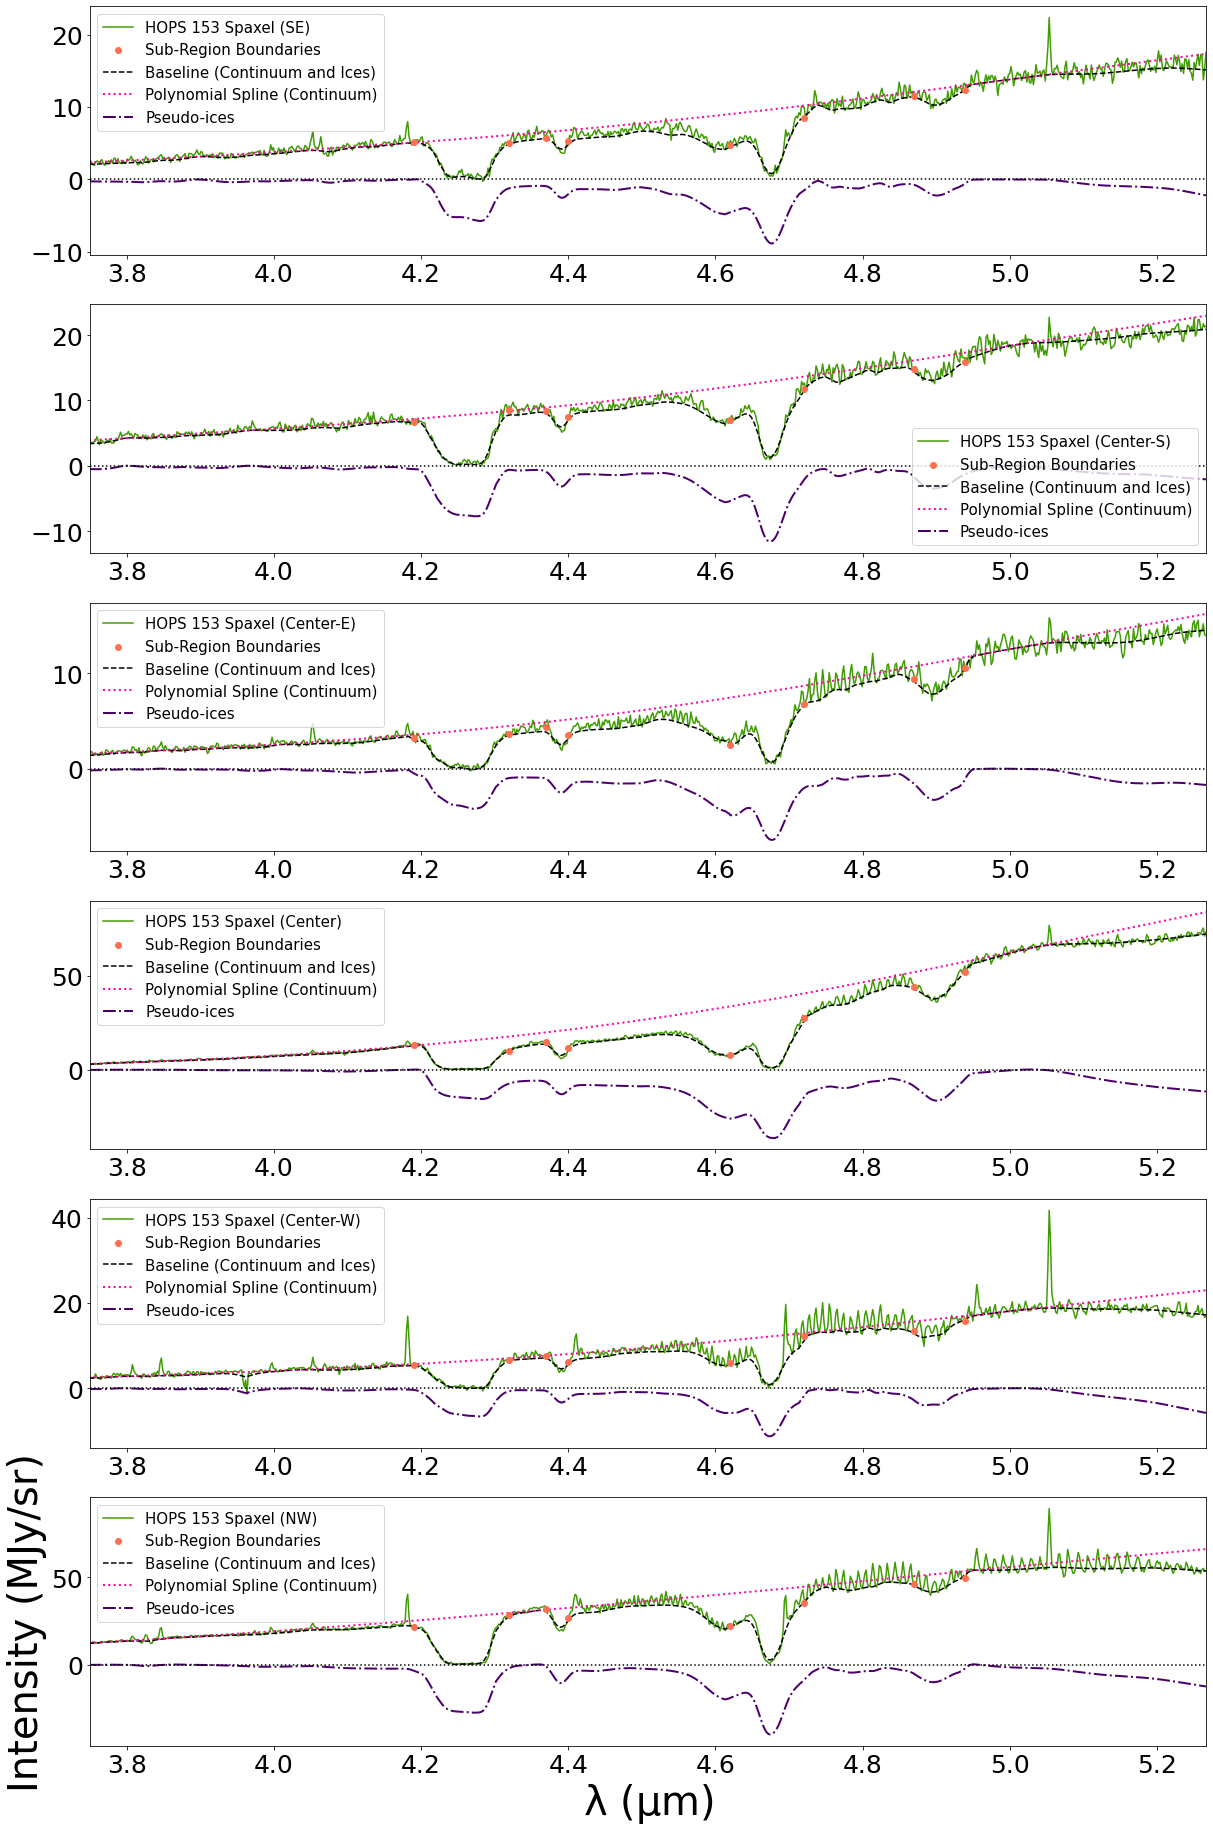

In [266]:
#testing an initial filter + interpolation for baselines

#read in some data
protostar_ind = 2 #CHANGE: to change protostars
hdul = fits.open(cube_file_list[protostar_ind])
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
cube = fits.getdata(cube_file_list[protostar_ind])

# define the wavelength grid (microns) from the header, always the same
wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1]

#now that we have chosen a protostar...
#create list of coordinates and wavelength regimes to loop over; also labels for the different locations
source_coords = [(39, 29),  (37, 43), (43, 47), (48, 47), (49, 53), (56, 49)]
source_labels = ['SE', 'Center-S', 'Center-E', 'Center', 'Center-W', 'NW']
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.72, 4.87, 4.939])
smooth_list = [1, 1, 10, 1, 5, 3, 1, 2, 10] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 100, 7, 1] #regularization parameter (relative levels of noise and signal)
# param_secondtolast = [2, 7]

#then set up a figure to loop over
fig, ax_list = plt.subplots(figsize=(20,32), nrows=6) #setup fig, axes #make a figure to plot various locations on an image

#and loop over the axes and coordinates for a given object
for i in range(len(ax_list)):
    ax = ax_list[i]

    # extracting spectra
    # cont_sources = [(48,46), (32,30), (46, 47), (62, 67), (48, 46)] #centered on a location with fewer lines, better for smoothing directly
    # flux_1pix = cube[:, cont_sources[protostar_ind][0], cont_sources[protostar_ind][1]] 
    # source_coords = [(48,46), (44,44), (44, 41), (41, 45), (38, 42)] #centered on a location with more lines, better with knots...also for fewer artifacts
    flux_1pix = cube[:, int(source_coords[i][0]), int(source_coords[i][1]) ][1:-1] #for an example of a single pixel, but cut off the ends of the spectrum for better fitting results
    # flux_1pix = flux_1pix[wave_mask]
    ax.plot(wave, flux_1pix, color='xkcd:grassy green', label=protostar_names[protostar_ind] + ' Spaxel ' + '(' + source_labels[i] + ')') #plot observation here!

    #preset the top hat filter version
    baseline_fitter = Baseline(wave, check_finite=False)
    bkg_top = baseline_fitter.tophat(flux_1pix, half_window=3)[0]

    #formulating regimes to cutoff the spectrum and apply different smoothing factors
    cutoffs_flux_matched = bkg_top[[np.abs(wave - j).argmin() for j in wave_cutoff_list]]
    ax.scatter(wave_cutoff_list, cutoffs_flux_matched, color='xkcd:orange pink', zorder=100, label='Sub-Region Boundaries') #or can use oranges 

    #begin to loop through different parameters, defining a new baseline for a given section of the spectrum
    baseline_list = []

    #if edge case at start, do it by hand to omit conditionals
    # print('start', wave_cutoff_list[0])
    cutoff_mask = wave < wave_cutoff_list[0] #define mask up to first marker
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #if between two values and not at the edge cases, we loop..
    cutoff_ind = 1 #to count loops
    while cutoff_ind <= len(wave_cutoff_list)-1:
        idx = (wave >= wave_cutoff_list[cutoff_ind-1]) & (wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with *
        cutoff_mask = np.where(idx)[0] #determine mask between two values
        # print('middle checks: ', cutoff_ind, wave_cutoff_list[cutoff_ind], len(flux_1pix[cutoff_mask]))

        #compute baseline
        baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)
        baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #update counter for loop, do after everything else
        cutoff_ind += 1

    #if edge case at end, do it by hand
    # print('end', wave_cutoff_list[-1]) #print to confirm cutoff at end
    cutoff_mask = wave > wave_cutoff_list[-1] #define mask past last marker
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    # baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
    baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=2e2, p=0.99, spline_degree=3)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #now trying to filter around our control or anchor points
    N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
    for cutoff_ind in range(len(wave_cutoff_list)):
        idx = ( wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
        idx_mask = np.where(idx)[0] #making mask
        baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=7) #in region around mask, apply filters

    #plotting 
    ax.plot(wave, baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
    # ax.plot(wave, flux_1pix-baseline_list, color='xkcd:twilight blue', label='Line Emission') #data

    #formulating a pseudo-continuum based on the baseline to determine ices and a transmission curve
    baseline_fitter = Baseline(wave, check_finite=False)
    ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e2, p=0.9999, spline_degree=2)[0]
    ax.plot(wave, ice_list, linewidth=2, color='xkcd:shocking pink', linestyle=':', label='Polynomial Spline (Continuum)') # or can use xkcd:carnation pink
    ax.plot(wave, baseline_list - ice_list, linewidth=2, color='xkcd:royal purple', linestyle='-.', label='Pseudo-ices')

    #formatting plot
    ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
    # ax.set_xticks(np.arange(3, 5.25, 0.25))
    ax.set_xlim(3.75, np.max(wave))
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.legend(loc='best', fontsize=15)
    if i == len(ax_list) - 1:
        ax.set_ylabel('Intensity (MJy/sr)', fontsize=40)
        ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
    # fig.savefig('CentralSource_CO/' + cube_file_list[protostar_ind].split('/')[0]+'_FindBaseline.pdf')

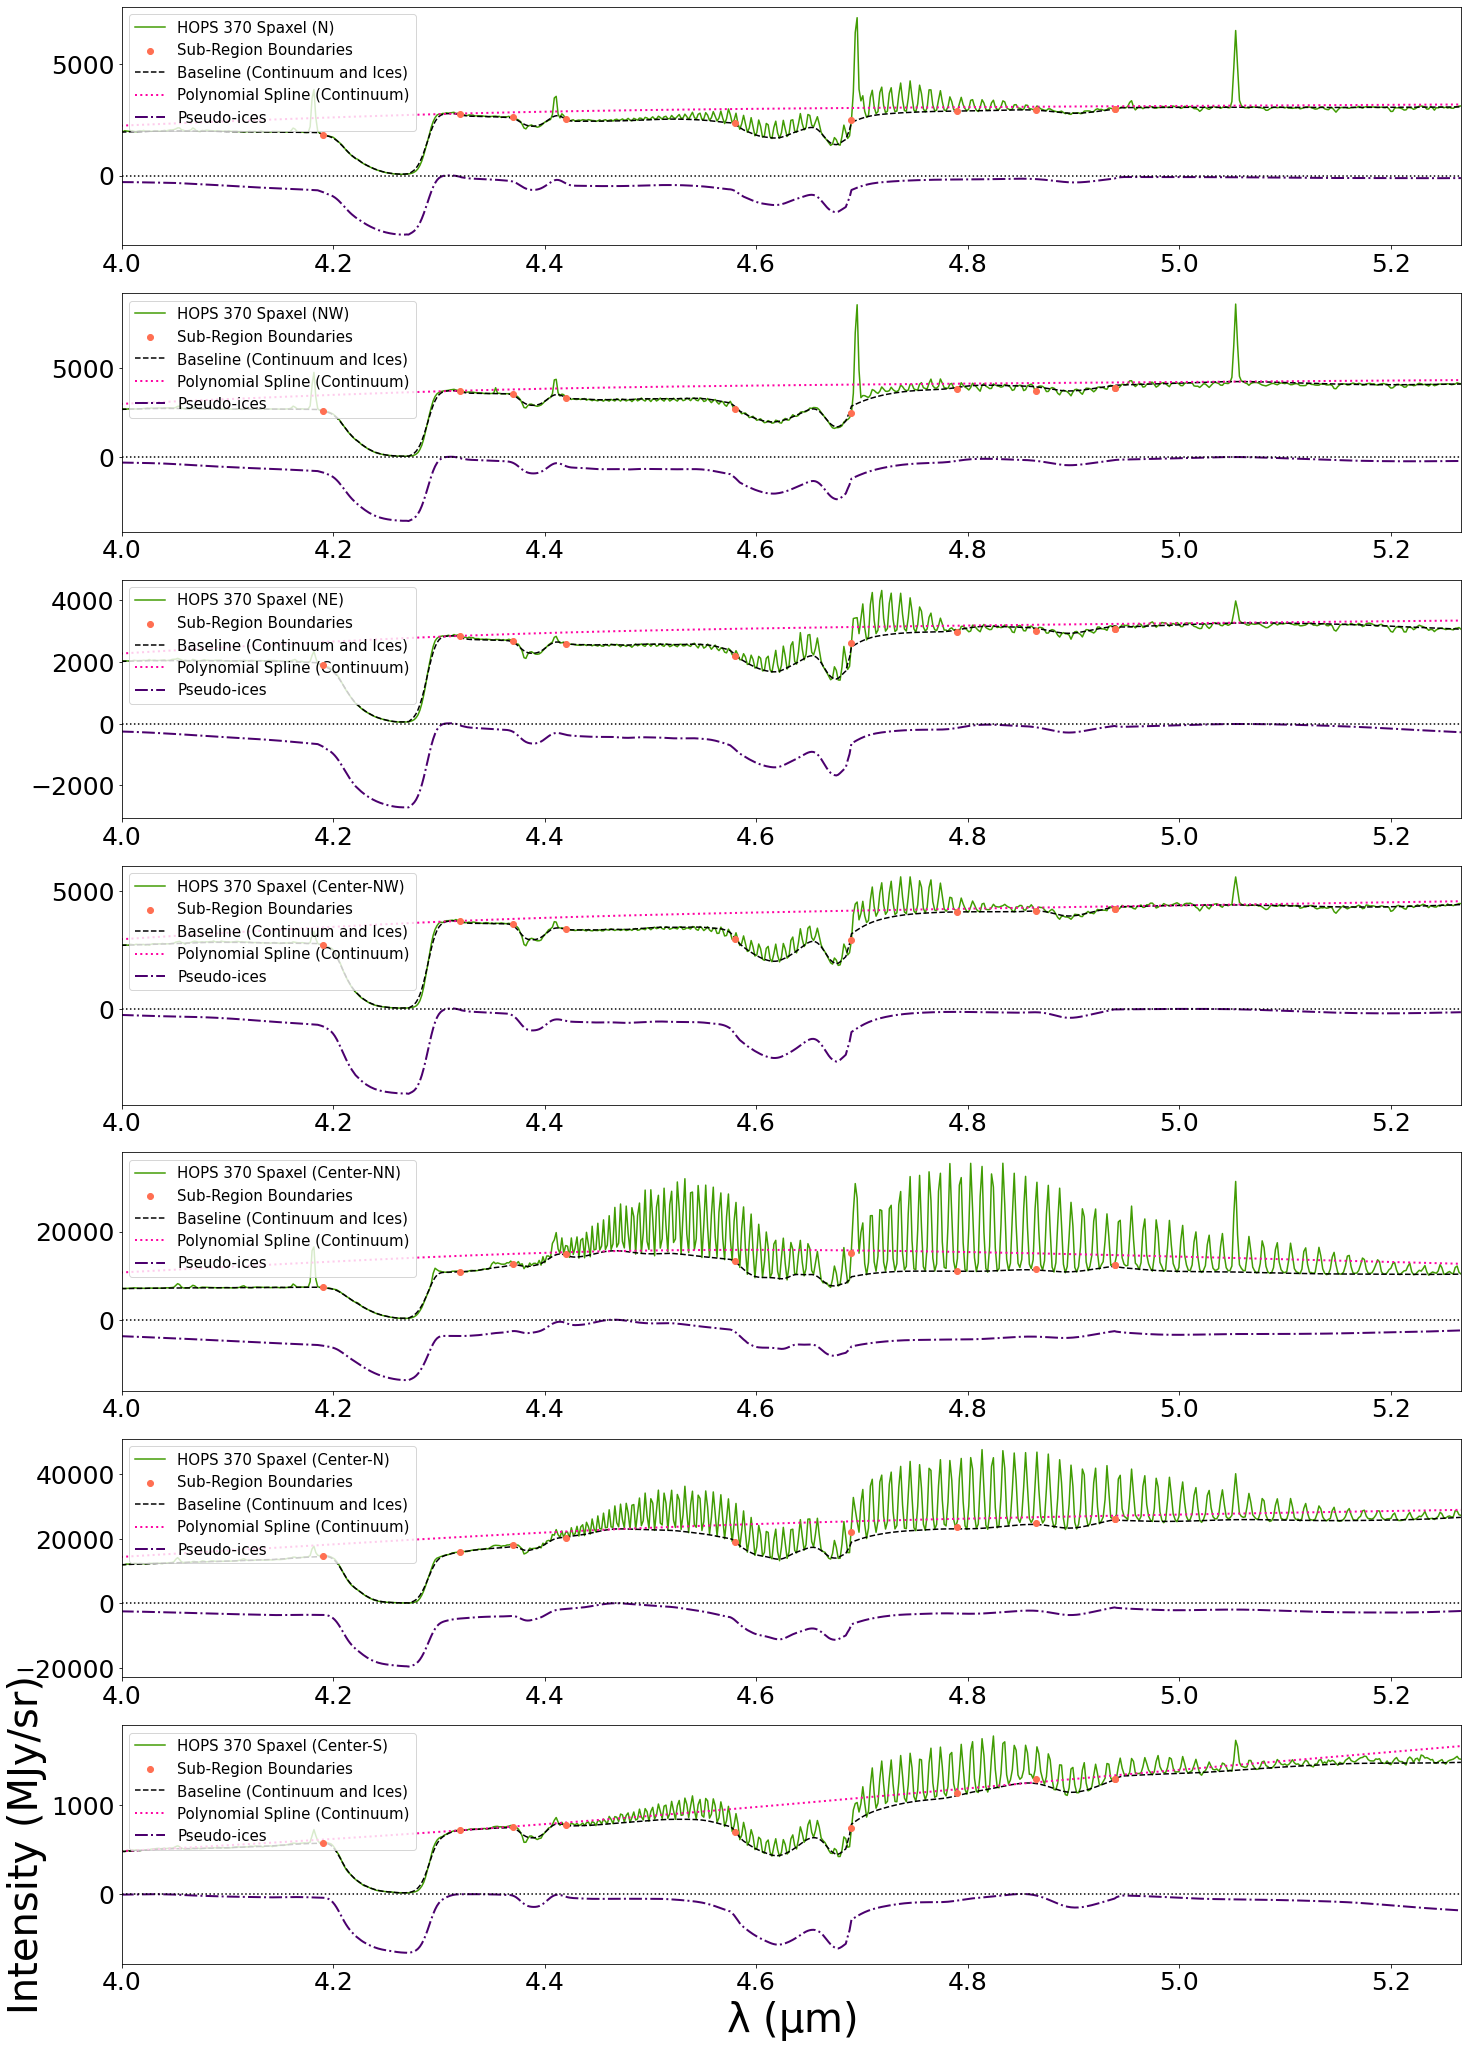

In [267]:
#testing an initial filter + interpolation for baselines

#read in some data
protostar_ind = 3 #CHANGE: to change protostars
hdul = fits.open(cube_file_list[protostar_ind])
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
cube = fits.getdata(cube_file_list[protostar_ind])

# define the wavelength grid (microns) from the header, always the same
wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1]

#read in a cube that shows if each co line is in emission or absorption
cube_absorb_emiss = fits.getdata(absorb_emiss_cube_list[protostar_ind])
co_refs_txt = np.genfromtxt(absorb_emiss_txt_list[protostar_ind], delimiter=',', skip_header=1) # text file used to match indices to a given CO line

#now that we have chosen a protostar...
#create list of coordinates and wavelength regimes to loop over; also labels for the different locations
source_coords = [(70, 42),  (66, 56), (61, 32), (57, 51), (53, 42), (47, 42), (41, 38)]
source_labels = ['N', 'NW', 'NE', 'Center-NW', 'Center-NN', 'Center-N', 'Center-S']
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.42, 4.58, 4.69, 4.79, 4.865, 4.939])
smooth_list = [1, 1, 10, 1, 5, 1, 10, 10, 2] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 1, 1, 7] #regularization parameter (relative levels of noise and signal)
# param_secondtolast = [2, 7]

#then set up a figure to loop over
fig, ax_list = plt.subplots(figsize=(24,36), nrows=7) #setup fig, axes #make a figure to plot various locations on an image

#and loop over the axes and coordinates for a given object
for i in range(len(ax_list)):
    ax = ax_list[i]

    # extracting spectra
    flux_1pix = cube[:, int(source_coords[i][0]), int(source_coords[i][1]) ][1:-1] #for an example of a single pixel, but cut off the ends of the spectrum for better fitting results
    ax.plot(wave, flux_1pix, color='xkcd:grassy green', label=protostar_names[protostar_ind] + ' Spaxel ' + '(' + source_labels[i] + ')') #plot observation here!

    #preset the top hat filter version
    baseline_fitter = Baseline(wave, check_finite=False)
    bkg_top = baseline_fitter.tophat(flux_1pix, half_window=3)[0]

    #begin to loop through different parameters, defining a new baseline for a given section of the spectrum
    baseline_list = []
    wave_cutoff_mod_list = [] #updated version of the above list...

    #if edge case at start, do it by hand to omit conditionals
    cutoff_mask = wave < wave_cutoff_list[0] #define mask up to first marker
    wave_cutoff_mod_list.append(wave_cutoff_list[0]) #just so we're consistent with the start and ending points
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list


    #if between two values and not at the edge cases, we loop..
    cutoff_ind = 1 #to count loops
    while cutoff_ind <= len(wave_cutoff_list)-1:
        #take region of spectrum
        idx = (wave >= wave_cutoff_list[cutoff_ind-1]) & (wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with * or & from PRIOR breakpoint
        cutoff_mask = np.where(idx)[0] #determine mask between two values
        baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)

        #loop through many CO spectral lines to determine each individual baseline 
        if wave_cutoff_list[cutoff_ind] < 4.41: # len(co_line_wave_mask) == 0: #first check if we have to either by # of CO lines or wavelength itself
            wave_cutoff_mod_list.append(wave_cutoff_list[cutoff_ind])
            baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
        else:
            #search for CO lines in the wavelength region we are concerned with
            #first, mask the text file array of lines using the initial cutoff point GUESSES, which we'll use to update the points
            # co_line_boundary_mask = np.where((co_refs_txt[:, 1] >= wave_cutoff_list[cutoff_ind] - 0.1) \
            #                              & (co_refs_txt[:, 1] <= wave_cutoff_list[cutoff_ind] + 0.1))[0]

            #first we find corresponding matched lines by wavelength from our co_txt and the set's mode in cube_absorp_emiss
            # line_absorb_emiss_boundaries = cube_absorb_emiss[co_line_boundary_mask, int(source_coords[i][0]), int(source_coords[i][1])]
            
            # before computing the mode, we want to actually modify our breakpoints...
            '''
            now move the break point to a spot between -1 to +1 or +1 to -1 (signifying the absorption to emission switchover)
            ...maybe see if that spot is guaranteed by having +/- 10 array elements on either side having a constant sign?
            THIS spot gets plotted on the spectrum, then we can continue...
            ''' 
            # cutoff_index = point where we have the most +1 or -1 on either side...but what if all -1 or all +1?
            # np.diff(np.sign(line_absorb_emiss_boundaries))
            # wave_cutoff_mod = wave_cutoff_list[cutoff_ind] +/- 0.1 '???'
            wave_cutoff_mod_list.append(wave_cutoff_list[cutoff_ind])

            #given newly updated cutoffs, we compute the mode of the region to see if mostly absorption or emission
            co_line_wave_mask = np.where((co_refs_txt[:, 1] >= wave_cutoff_mod_list[cutoff_ind-1]) \
                                & (co_refs_txt[:, 1] <= wave_cutoff_mod_list[cutoff_ind]))[0]
            line_absorb_emiss_match = cube_absorb_emiss[co_line_wave_mask, int(source_coords[i][0]), int(source_coords[i][1])]
            vals, counts = np.unique(line_absorb_emiss_match, return_counts=True) #find number of unique elements of -1, 1, or 0 to determine bool
            absorb_emiss_mode = vals[np.argmax(counts)] #count bools to determine mode

            #now using the mode to pick and compute the correct baseline
            if absorb_emiss_mode == 1: #emission, do old way
                baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
                # baseline = baseline_fitter.asls(flux_1pix[cutoff_mask], lam=1e2, p=0.9)[0]
            elif absorb_emiss_mode == -1: #absorption, change slightly
                baseline = baseline_fitter.pspline_asls(flux_1pix[cutoff_mask], p=0.9, lam=1e1)[0]
                # baseline = baseline_fitter.noise_median(flux_1pix[cutoff_mask], half_window=2)[0] 
            else: #default to original if we can't figure anything else out...
                # baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
                baseline = baseline_fitter.noise_median(flux_1pix[cutoff_mask], half_window=2)[0] 
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #update counter for loop, do after everything else
        cutoff_ind += 1

    #if edge case at end, do it by hand
    cutoff_mask = wave > wave_cutoff_list[-1] #define mask past last marker
    wave_cutoff_mod_list.append(wave_cutoff_list[-1]) #for consistency
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline

    #given newly updated cutoffs, we compute the mode of the region to see if mostly absorption or emission
    co_line_wave_mask = np.where((co_refs_txt[:, 1] >= wave_cutoff_mod_list[-1]))[0]
    line_absorb_emiss_match = cube_absorb_emiss[co_line_wave_mask, int(source_coords[i][0]), int(source_coords[i][1])]
    vals, counts = np.unique(line_absorb_emiss_match, return_counts=True) #find number of unique elements of -1, 1, or 0 to determine bool
    absorb_emiss_mode = vals[np.argmax(counts)] #count bools to determine mode

    if absorb_emiss_mode != 1:
        baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=1e2, p=0.999, spline_degree=3)[0]
    else:
        baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=1e3, p=0.1, spline_degree=2)[0]
        # baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list


    #now that we're done with the bulk of fitting...
    #formulating regimes to cutoff the spectrum and apply different smoothing factors
    cutoffs_flux_matched = bkg_top[[np.abs(wave - j).argmin() for j in wave_cutoff_mod_list]]
    # ax.scatter(wave_cutoff_list, [0]*len(wave_cutoff_list), color='xkcd:red', zorder=100, label='Original Sub-Region Boundaries') #or can use oranges 
    ax.scatter(wave_cutoff_mod_list, cutoffs_flux_matched, color='xkcd:orange pink', zorder=100, label='Sub-Region Boundaries') #or can use oranges 


    # now trying to filter around our control or anchor points
    N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
    for cutoff_ind in range(len(wave_cutoff_list)):
        idx = ( wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
        idx_mask = np.where(idx)[0] #making mask
        baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=5) #in region around mask, apply filters

    #in case we want to do any last changes by hand, we can do them here...

    # formulating a pseudo-continuum based on the baseline to determine ices and a transmission curve
    baseline_fitter = Baseline(wave, check_finite=False)
    ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e2, p=0.9999, spline_degree=2)[0]

    # for third to last case AFTER doing everything, we need to splice in a correction to follow the continuum
    idx = (wave >= wave_cutoff_list[len(wave_cutoff_list)-4]) & (wave <= wave_cutoff_list[len(wave_cutoff_list)-1])
    idx_mask = np.where(idx)[0] #making mask
    baseline_fitter = Baseline(wave[idx_mask], check_finite=False)
    # baseline_list[idx_mask] = baseline_fitter.tophat(baseline_list[idx_mask], half_window=2)[0]
    baseline_list[idx_mask] = baseline_fitter.pspline_asls(baseline_list[idx_mask], lam=3e1, p =0.1)[0]

    #plotting final version
    ax.plot(wave, baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
    # ax.plot(co_wave_list, co_baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
    # ax.plot(wave, flux_1pix-baseline_list, color='xkcd:twilight blue', label='Line Emission') #data

    # repeating this step for consistency...
    baseline_fitter = Baseline(wave, check_finite=False)
    ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e2, p=0.9999, spline_degree=2)[0]
    ax.plot(wave, ice_list, linewidth=2, color='xkcd:shocking pink', linestyle=':', label='Polynomial Spline (Continuum)') # or can use xkcd:carnation pink
    ax.plot(wave, baseline_list - ice_list, linewidth=2, color='xkcd:royal purple', linestyle='-.', label='Pseudo-ices')


    #computing and plotting the gradient...aka 1D derivatives
    # ax.plot(wave, 5*np.gradient(np.gradient(np.gradient(np.gradient(flux_1pix)))))

    #formatting plot
    ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
    # ax.set_xticks(np.arange(3, 5.25, 0.25))
    ax.set_xlim(4, np.max(wave))
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.legend(loc='upper left', fontsize=15)
    if i == len(ax_list) - 1:
        ax.set_ylabel('Intensity (MJy/sr)', fontsize=40)
        ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
    # fig.savefig('CentralSource_CO/' + cube_file_list[protostar_ind].split('/')[0]+'_FindBaseline.pdf')

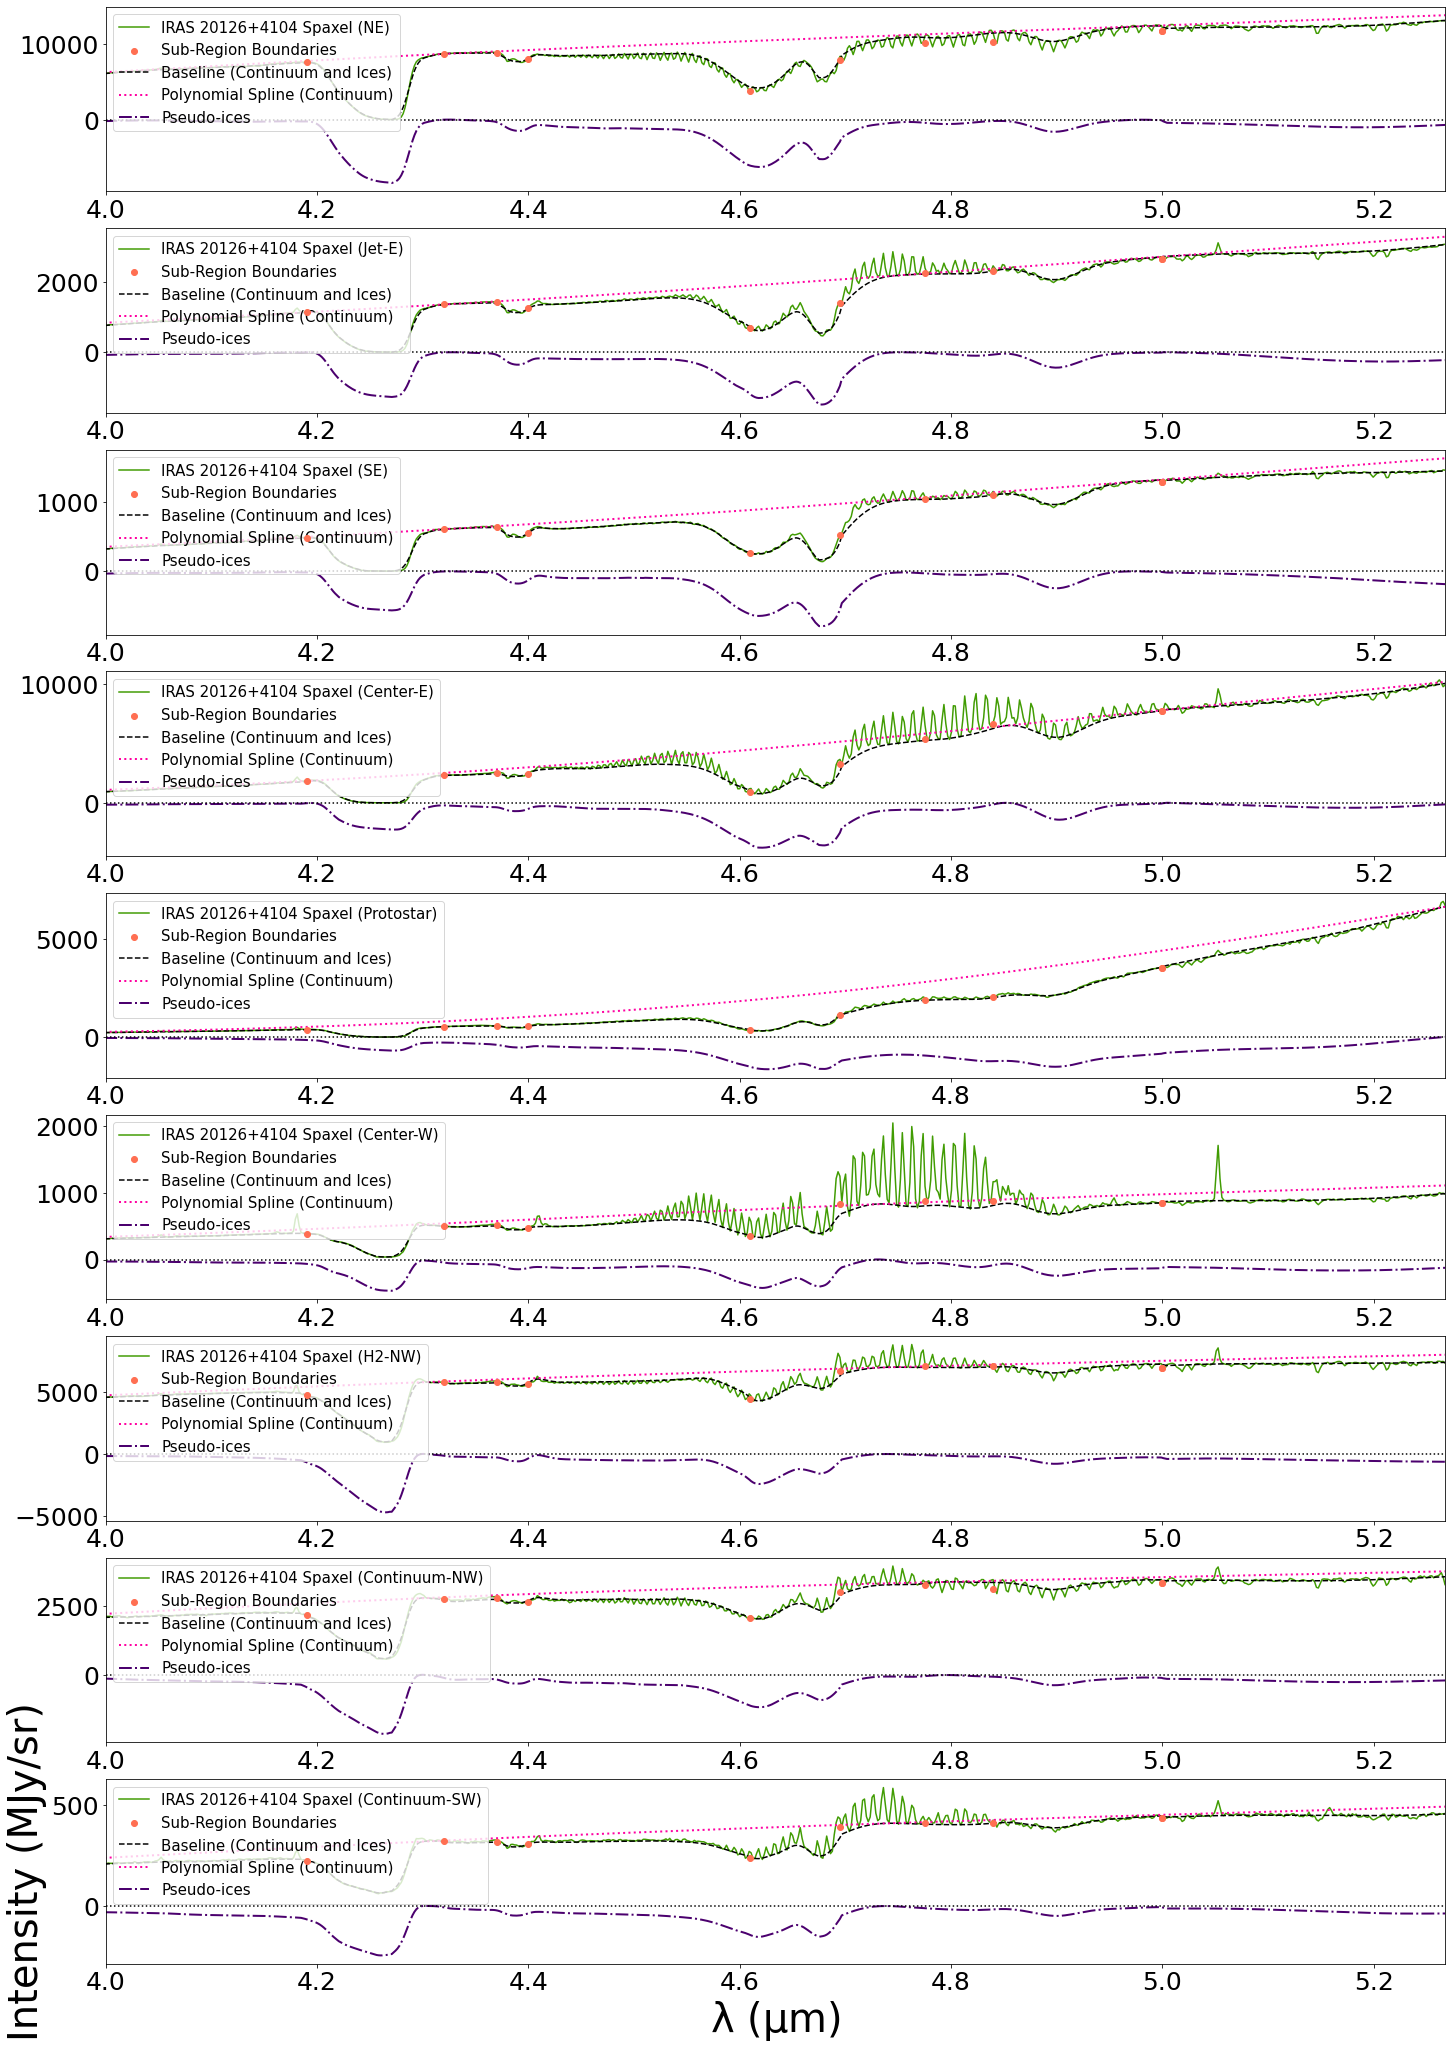

In [5]:
#testing an initial filter + interpolation for baselines

#read in some data
protostar_ind = 4 #CHANGE: to change protostars
hdul = fits.open(cube_file_list[protostar_ind])
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
cube = fits.getdata(cube_file_list[protostar_ind])

# define the wavelength grid (microns) from the header, always the same
wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1]

#read in a cube that shows if each co line is in emission or absorption
cube_absorb_emiss = fits.getdata(absorb_emiss_cube_list[protostar_ind])
co_refs_txt = np.genfromtxt(absorb_emiss_txt_list[protostar_ind], delimiter=',', skip_header=1) # text file used to match indices to a given CO line

#now that we have chosen a protostar...
#create list of coordinates and wavelength regimes to loop over; also labels for the different locations
source_coords = [(45,25),  (36,33), (27,34), (44,44), (47,49), (51,54), (60,63), (69,66), (76,52)]
source_labels = ['NE', 'Jet-E', 'SE', 'Center-E', 'Protostar', 'Center-W', 'H2-NW', 'Continuum-NW', 'Continuum-SW']
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.61, 4.695, 4.775, 4.84, 5.0]) # 4.939
smooth_list = [1, 1, 10, 1, 5, 3, 15, 10, 2, 10] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 0.1, 100, 7, 1] #regularization parameter (relative levels of noise and signal)

#then set up a figure to loop over
fig, ax_list = plt.subplots(figsize=(24,36), nrows=9) #setup fig, axes #make a figure to plot various locations on an image

#and loop over the axes and coordinates for a given object
for i in range(len(ax_list)):
    ax = ax_list[i]

    # extracting spectra
    flux_1pix = cube[:, int(source_coords[i][0]), int(source_coords[i][1]) ][1:-1] #for an example of a single pixel, but cut off the ends of the spectrum for better fitting results
    ax.plot(wave, flux_1pix, color='xkcd:grassy green', label=protostar_names[protostar_ind] + ' Spaxel ' + '(' + source_labels[i] + ')') #plot observation here!

    #preset the top hat filter version
    baseline_fitter = Baseline(wave, check_finite=False)
    bkg_top = baseline_fitter.tophat(flux_1pix, half_window=3)[0]

    #begin to loop through different parameters, defining a new baseline for a given section of the spectrum
    baseline_list = []
    wave_cutoff_mod_list = [] #updated version of the above list...

    #if edge case at start, do it by hand to omit conditionals
    cutoff_mask = wave < wave_cutoff_list[0] #define mask up to first marker
    wave_cutoff_mod_list.append(wave_cutoff_list[0]) #just so we're consistent with the start and ending points
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list


    #if between two values and not at the edge cases, we loop..
    cutoff_ind = 1 #to count loops
    while cutoff_ind <= len(wave_cutoff_list)-1:
        #take region of spectrum
        idx = (wave >= wave_cutoff_list[cutoff_ind-1]) & (wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with * or & from PRIOR breakpoint
        cutoff_mask = np.where(idx)[0] #determine mask between two values
        baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)

        #loop through many CO spectral lines to determine each individual baseline 
        if wave_cutoff_list[cutoff_ind] < 4.41: # len(co_line_wave_mask) == 0: #first check if we have to either by # of CO lines or wavelength itself
            wave_cutoff_mod_list.append(wave_cutoff_list[cutoff_ind])
            baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
        else:
            #search for CO lines in the wavelength region we are concerned with
            #first, mask the text file array of lines using the initial cutoff point GUESSES, which we'll use to update the points
            # co_line_boundary_mask = np.where((co_refs_txt[:, 1] >= wave_cutoff_list[cutoff_ind] - 0.1) \
            #                              & (co_refs_txt[:, 1] <= wave_cutoff_list[cutoff_ind] + 0.1))[0]

            #first we find corresponding matched lines by wavelength from our co_txt and the set's mode in cube_absorp_emiss
            # line_absorb_emiss_boundaries = cube_absorb_emiss[co_line_boundary_mask, int(source_coords[i][0]), int(source_coords[i][1])]
            
            # before computing the mode, we want to actually modify our breakpoints...
            '''
            now move the break point to a spot between -1 to +1 or +1 to -1 (signifying the absorption to emission switchover)
            ...maybe see if that spot is guaranteed by having +/- 10 array elements on either side having a constant sign?
            THIS spot gets plotted on the spectrum, then we can continue...
            ''' 
            # cutoff_index = point where we have the most +1 or -1 on either side...but what if all -1 or all +1?
            # np.diff(np.sign(line_absorb_emiss_boundaries))
            # wave_cutoff_mod = wave_cutoff_list[cutoff_ind] +/- 0.1 '???'
            wave_cutoff_mod_list.append(wave_cutoff_list[cutoff_ind])

            #given newly updated cutoffs, we compute the mode of the region to see if mostly absorption or emission
            co_line_wave_mask = np.where((co_refs_txt[:, 1] >= wave_cutoff_mod_list[cutoff_ind-1]) \
                                & (co_refs_txt[:, 1] <= wave_cutoff_mod_list[cutoff_ind]))[0]
            line_absorb_emiss_match = cube_absorb_emiss[co_line_wave_mask, int(source_coords[i][0]), int(source_coords[i][1])]
            vals, counts = np.unique(line_absorb_emiss_match, return_counts=True) #find number of unique elements of -1, 1, or 0 to determine bool
            absorb_emiss_mode = vals[np.argmax(counts)] #count bools to determine mode

            #now using the mode to pick and compute the correct baseline
            if absorb_emiss_mode == 1 and cutoff_ind != len(wave_cutoff_list) - 3: #emission, do old way
                baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
                # baseline = baseline_fitter.asls(flux_1pix[cutoff_mask], lam=1e2, p=0.9)[0]
            elif absorb_emiss_mode == 1 and cutoff_ind == len(wave_cutoff_list) - 3:
                # baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]            
                baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], p=0.045, lam=3e3)[0] 
            elif absorb_emiss_mode == -1: #absorption, change slightly
                baseline = baseline_fitter.pspline_asls(flux_1pix[cutoff_mask], p=0.9, lam=1e1)[0]
                # baseline = baseline_fitter.noise_median(flux_1pix[cutoff_mask], half_window=2)[0] 
            else: #default to original if we can't figure anything else out...
                # baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
                baseline = baseline_fitter.noise_median(flux_1pix[cutoff_mask], half_window=2)[0] 
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #update counter for loop, do after everything else
        cutoff_ind += 1

    #if edge case at end, do it by hand
    cutoff_mask = wave > wave_cutoff_list[-1] #define mask past last marker
    wave_cutoff_mod_list.append(wave_cutoff_list[-1]) #for consistency
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    # baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
    baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=1e2, p=0.999, spline_degree=3)[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #now that we're done with the bulk of fitting...
    #formulating regimes to cutoff the spectrum and apply different smoothing factors
    cutoffs_flux_matched = bkg_top[[np.abs(wave - j).argmin() for j in wave_cutoff_mod_list]]
    # ax.scatter(wave_cutoff_list, [0]*len(wave_cutoff_list), color='xkcd:red', zorder=100, label='Original Sub-Region Boundaries') #or can use oranges 
    ax.scatter(wave_cutoff_mod_list, cutoffs_flux_matched, color='xkcd:orange pink', zorder=100, label='Sub-Region Boundaries') #or can use oranges 


    # now trying to filter around our control or anchor points
    N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
    for cutoff_ind in range(len(wave_cutoff_list)):
        idx = ( wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
        idx_mask = np.where(idx)[0] #making mask
        baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=5) #in region around mask, apply filters

    #in case we want to do any last changes by hand, we can do them here...

    # formulating a pseudo-continuum based on the baseline to determine ices and a transmission curve
    baseline_fitter = Baseline(wave, check_finite=False)
    ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e2, p=0.9999, spline_degree=2)[0]

    # for third to last case AFTER doing everything, we need to splice in a correction to follow the continuum
    idx = (wave >= wave_cutoff_list[len(wave_cutoff_list)-4]) & (wave <= wave_cutoff_list[len(wave_cutoff_list)-1])
    idx_mask = np.where(idx)[0] #making mask
    baseline_fitter = Baseline(wave[idx_mask], check_finite=False)
    # baseline_list[idx_mask] = baseline_fitter.tophat(baseline_list[idx_mask], half_window=2)[0]
    baseline_list[idx_mask] = baseline_fitter.pspline_asls(baseline_list[idx_mask], lam=3e1, p =0.1)[0]

    #plotting final version
    ax.plot(wave, baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
    # ax.plot(co_wave_list, co_baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
    # ax.plot(wave, flux_1pix-baseline_list, color='xkcd:twilight blue', label='Line Emission') #data

    # repeating this step for consistency...
    baseline_fitter = Baseline(wave, check_finite=False)
    ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e2, p=0.9999, spline_degree=2)[0]
    ax.plot(wave, ice_list, linewidth=2, color='xkcd:shocking pink', linestyle=':', label='Polynomial Spline (Continuum)') # or can use xkcd:carnation pink
    ax.plot(wave, baseline_list - ice_list, linewidth=2, color='xkcd:royal purple', linestyle='-.', label='Pseudo-ices')


    #computing and plotting the gradient...aka 1D derivatives
    # ax.plot(wave, 5*np.gradient(np.gradient(np.gradient(np.gradient(flux_1pix)))))

    #formatting plot
    ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
    # ax.set_xticks(np.arange(3, 5.25, 0.25))
    ax.set_xlim(4, np.max(wave))
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.legend(loc='upper left', fontsize=15)
    if i == len(ax_list) - 1:
        ax.set_ylabel('Intensity (MJy/sr)', fontsize=40)
        ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
    # fig.savefig('CentralSource_CO/' + cube_file_list[protostar_ind].split('/')[0]+'_FindBaseline.pdf')

(4.45, 5.3876608595271716)

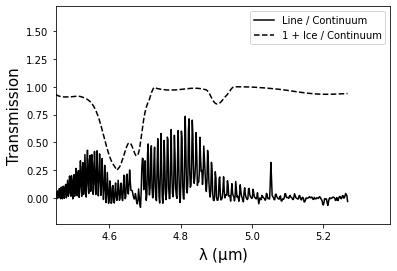

In [66]:
#separately plotting the transmission curve to check
plt.plot(wave, (flux_1pix - baseline_list)/(ice_list), 'k-', label='Line / Continuum') #if interested in line to continuum ratio
plt.plot(wave, 1 + (baseline_list - ice_list)/(ice_list), 'k--', label='1 + Ice / Continuum') #if interested in ice to continuum ratio

#formatting
plt.legend()
plt.ylabel('Transmission', fontsize=15)
plt.xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=15)
# plt.ylim(0,)
plt.xlim(4.45,)


' after creating file, add to the header\n\nfile: 1D spectrum by Adam Rubinstein\nprotostar: IRAS 16253\nstat method: sum\naperture shape: square\naperture side length or diameter: 1 arcsec\nadditional notes: baseline fitted and subtracted using pybaselines tophat, then jbcd methods. \nadditional notes: centered using alma coordinates\n\n'

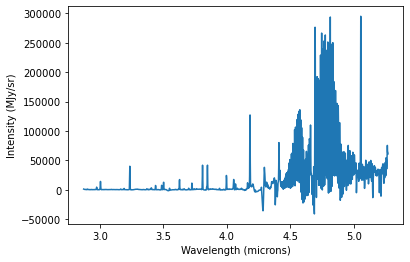

In [22]:
# Read in a 3-D IFU datacube of interest, and header
#first, note the path
protostar_folders = ['IRAS16253', 'B335', 'HOPS153', 'HOPS370', 'IRAS20126']
protostar_ind = 4
cube_file_list = [glob('Baseline_Subtracted/' + i + '*.fits')[0].replace('\\', '/') for i in protostar_folders] #change the wildcard '*' here!

# Read in a 3-D IFU datacube of interest, and header
#first, note the path
cube_file = cube_file_list[protostar_ind]
hdul = fits.open(cube_file)
cube = fits.getdata(cube_file)
nirspec_cube = SpectralCube.read(hdul[0]) #accessing the cube for data  
header_cube = hdul[0].header

# define the wavelength grid (microns) from the header
# offset_list = [1.95e-3, 2e-3, 9.75e-4, 1.05e-3, 1.825e-3] #done by hand
offset_list = [1.85e-3, 2e-3, 1.1e-3, 1.1e-3, 2.25e-3] #experimental round 2 with initial changes to baselines
wave_offset = offset_list[protostar_ind] #unit = microns, alt value is 2e-4 microns, while cdelt is about E-9 m or E-3 mic...
wave_factor = 1 #/1.001 #for wavelength calibrating
wave_units = 1e6 #to convert from meters to microns
wave = wave_factor * wave_units * nirspec_cube.spectral_axis.value + wave_offset

# make a simple 1d spectrum of the central region, taking sum or median to attempt to account for cosmic rays
# central_sources = [(48,45), (44,43), (47, 52), (41, 45), (46, 48)]
# central_sources = [(48,46), (44,44), (44, 41), (41, 45), (38, 42)] #this one has fewer artifacts
central_sources = [(int(46.57459417809592), int(45.12978229)),  (int(46.73250708463416), int(43.13112798)), (int(46.47088442936513), int(46.6279981)), \
                        (int(41.71119797770727), int(43.61467905)), (int(43.38667807448542), int(43.15705917))]

arc_to_pix = 1 * 2.7777778191699e-05 * 3600.0
center_widths = [int(1 / arc_to_pix)] * 5
flux1 = np.sum(cube[:, central_sources[protostar_ind][0]-center_widths[protostar_ind]:central_sources[protostar_ind][1]+center_widths[protostar_ind],\
                       central_sources[protostar_ind][0]-center_widths[protostar_ind]:central_sources[protostar_ind][1]+center_widths[protostar_ind]], \
                        axis=(1,2)) #for an example of a single pixel
# flux1 = cube[:, int(central_sources[protostar_ind][0]), int(central_sources[protostar_ind][1]) ].astype(np.float32) #for an example of a single pixel
flux1 = np.nan_to_num(flux1)

#plot sample spectrum
plt.plot(wave, flux1)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Intensity (MJy/sr)')

#store spectra into dataframe and save it
df_spectrum = pd.DataFrame({'Wavelength(mic)':wave, 'Flux(MJy/sr)':flux1})
savepath = 'Spectra1D_tests/' + protostar_folders[protostar_ind] + '_baseFit_1dSpectrum.txt'
df_spectrum.to_csv(savepath)

''' after creating file, add to the header

file: 1D spectrum by Adam Rubinstein
protostar: IRAS 16253
stat method: sum
aperture shape: square
aperture side length or diameter: 1 arcsec
additional notes: baseline fitted and subtracted using pybaselines tophat, then jbcd methods. 
additional notes: centered using alma coordinates

'''